To start with, I have taken ideas from the following code esp. to see how GCN works. Although, it does not use any CNN. 

Node classification with Graph Convolutional Network (GCN). https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gcn-node-classification.html 

In [1]:
# import libraries

import os
import pandas as pd

In [2]:
# Import Libraries for Graph, GNN, and GCN

import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.layer import DeepGraphCNN
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

In [3]:
# Machine Learnig related library Imports

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
# eventually did not use this
drop_rows_with_na = 1

In [5]:
df = pd.DataFrame();
data_file = "nasdq-stock-price--all-merged.csv"; #"small-stock-price--all-merged.csv"
# stock-price--all-merged.csv"
data_file = "exp-1-nasdq-stock-price--all-merged.csv";
df = pd.read_csv("./data/" + data_file, low_memory = False);
df.head()

,Unnamed: 0,Ticker,Date,Low,Open,Volume,High,Close,Adjusted Close
0,10,AAL,2005-11-10,21.799999,22.2600002288818,764600.0,22.2999992370605,21.980000,20.721457
1,33,AAL,2005-11-11,33.000000,33.0499992370605,1183900.0,33.9500007629395,33.349998,31.440432
2,34,AAL,2005-11-14,33.450001,33.5,1059200.0,34.5,33.750000,31.817526
3,35,AAL,2005-11-15,32.840000,33.75,759200.0,33.8800010681152,33.880001,31.940084
4,36,AAL,2005-11-16,33.400002,33.5099983215332,542600.0,33.8499984741211,33.599998,31.676109


In [6]:
df_s =  df[ ['Ticker', 'Date', 'Adjusted Close'] ];
df_s

,Ticker,Date,Adjusted Close
0,AAL,2005-11-10,20.721457
1,AAL,2005-11-11,31.440432
2,AAL,2005-11-14,31.817526
3,AAL,2005-11-15,31.940084
4,AAL,2005-11-16,31.676109
...,...,...,...
202122,WDC,2022-12-07,46.029999
202123,WDC,2022-12-08,50.669998
202124,WDC,2022-12-09,43.270000
202125,WDC,2022-12-10,34.279999


In [7]:
df_s.shape

(202127, 3)

In [8]:
df_s["Date"] = df_s["Date"].astype('datetime64[ns]')
df_s = df_s.sort_values( by = 'Date', ascending = True )
df_s

C:\Users\sayed\AppData\Local\Temp\ipykernel_23796\690785714.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s["Date"] = df_s["Date"].astype('datetime64[ns]')


,Ticker,Date,Adjusted Close
0,AAL,2005-11-10,20.721457
47301,CCRN,2005-11-10,16.719999
159120,ROST,2005-11-10,5.499523
43000,CAR,2005-11-10,30.960777
163421,RRGB,2005-11-10,44.580002
...,...,...,...
12896,ALGN,2022-12-12,195.410004
189223,SWKS,2022-12-12,94.459999
107506,ISRG,2022-12-12,271.040009
150517,OKE,2022-12-12,64.739998


df_s = df_s[ df_s['Date'] >= "2005-11-09" ] 
df_s
df_s = df_s[ df_s['Date'] <= "2007-12-31" ] 
df_s.tail()

In [9]:
# DataFrame.pivot_table
df_s_pivot = df_s.pivot_table(index = 'Ticker', columns = 'Date', values = 'Adjusted Close')
df_s_pivot

Date,2005-11-10,2005-11-11,2005-11-14,2005-11-15,2005-11-16,2005-11-17,2005-11-18,2005-11-21,2005-11-22,2005-11-23,...,2022-11-29,2022-11-30,2022-12-01,2022-12-04,2022-12-05,2022-12-07,2022-12-08,2022-12-09,2022-12-10,2022-12-12
Ticker,,,,,,,,,,,,,,,,,,,,,
AAL,20.721457,31.440432,31.817526,31.940084,31.676109,32.354889,31.157598,30.158302,30.639097,31.148174,...,14.140000,14.430000,18.500000,17.129999,15.490000,14.770000,15.250000,14.470000,12.700000,13.915000
AAPL,1.570580,1.873492,1.870753,1.896021,1.977305,1.964215,1.965432,1.977609,2.025102,2.043063,...,141.169998,148.029999,174.517136,166.904938,142.126480,145.416443,171.814987,163.159332,138.110886,142.320007
ALGN,6.590000,6.980000,6.850000,6.730000,6.590000,6.300000,6.440000,6.270000,6.290000,6.750000,...,191.830002,196.660004,539.469971,406.230011,259.529999,248.979996,289.000000,267.790009,208.050003,195.410004
AMD,24.000000,24.760000,25.000000,25.500000,25.549999,25.889999,26.740000,27.040001,27.090000,26.219999,...,73.389999,77.629997,137.470001,95.099998,87.059998,76.360001,100.830002,84.639999,57.849998,69.169998
AMGN,57.224815,60.792927,61.205231,61.205231,60.905376,62.277153,62.382114,63.281658,62.861828,62.082233,...,281.989990,286.399994,224.663834,244.462387,239.261063,243.400879,244.800354,235.994522,244.754196,275.040009
AMZN,2.170000,2.134000,2.126500,2.222500,2.265000,2.337000,2.399000,2.399500,2.442500,2.412000,...,92.419998,96.540001,165.207001,150.787506,106.930496,109.220001,143.550003,136.449997,112.900002,88.605003
ATVI,6.393302,7.398454,7.575770,7.429485,7.478247,7.203409,6.729092,6.587240,6.503015,6.529612,...,74.339996,73.949997,64.427040,79.070000,77.379997,76.540001,80.790001,78.129997,73.500000,74.769997
BIDU,6.525000,7.005000,7.000000,6.882000,6.950000,7.318000,7.092000,7.160000,7.472000,8.049000,...,99.639999,108.599998,159.360001,130.990005,107.879997,143.479996,140.360001,139.559998,107.470001,114.949997
BIIB,36.570000,44.910000,43.740002,43.810001,43.720001,44.810001,45.330002,45.119999,44.759998,44.830002,...,291.410004,305.170013,225.339996,208.059998,194.320007,215.580002,220.990005,212.880005,253.669998,286.179993


df_s_pivot = df_s.pivot(index = 'Ticker', columns = 'Date', values = 'Adjusted Close')
df_s_pivot

In [10]:
# df_s_pivot.corr()

In [11]:
df_s_transpose = df_s_pivot.T
df_s_transpose

Ticker,AAL,AAPL,ALGN,AMD,AMGN,AMZN,ATVI,BIDU,BIIB,CAC,...,ROST,RRGB,SBUX,SEAC,SGEN,SIMO,SWKS,TXN,VRTX,WDC
Date,,,,,,,,,,,,,,,,,,,,,
2005-11-10,20.721457,1.570580,6.590000,24.000000,57.224815,2.170000,6.393302,6.525000,36.570000,13.136522,...,5.499523,44.580002,10.598515,6.4500,5.000000,10.724137,4.646201,20.624651,20.870001,9.673133
2005-11-11,31.440432,1.873492,6.980000,24.760000,60.792927,2.134000,7.398454,7.005000,44.910000,14.710688,...,5.587360,52.750000,12.496881,7.5300,5.660000,10.920407,4.438297,21.876820,26.330000,9.767348
2005-11-14,31.817526,1.870753,6.850000,25.000000,61.205231,2.126500,7.575770,7.000000,43.740002,14.694822,...,5.630208,52.689999,12.563198,7.5900,5.630000,11.422858,4.411180,22.411083,26.190001,9.610318
2005-11-15,31.940084,1.896021,6.730000,25.500000,61.205231,2.222500,7.429485,6.882000,43.810001,14.488638,...,5.396688,52.130001,12.550764,7.2500,5.370000,11.666232,4.375022,22.122852,25.990000,9.516099
2005-11-16,31.676109,1.977305,6.590000,25.549999,60.905376,2.265000,7.478247,6.950000,43.720001,14.357786,...,5.364550,52.160000,12.608795,7.1200,5.270000,11.265841,4.311746,22.179094,25.059999,9.955786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-07,14.770000,145.416443,248.979996,76.360001,243.400879,109.220001,76.540001,143.479996,215.580002,44.036304,...,75.070000,7.770000,77.760002,0.5400,179.000000,83.089996,96.510002,154.460007,290.010010,46.029999
2022-12-08,15.250000,171.814987,289.000000,100.830002,244.800354,143.550003,80.790001,140.360001,220.990005,47.541328,...,90.120003,8.800000,88.309998,0.5800,170.139999,82.610001,113.410004,185.380005,294.519989,50.669998
2022-12-09,14.470000,163.159332,267.790009,84.639999,235.994522,136.449997,78.129997,139.559998,212.880005,45.273212,...,94.980003,8.270000,89.070000,0.4800,150.100006,73.410004,103.620003,170.580002,293.480011,43.270000


In [12]:
if drop_rows_with_na == 1:
    df_s_transpose = df_s_transpose.dropna(axis=0);
    #df_s_transpose["Date"] = df_s_transpose["Date"].astype('datetime64[ns]')
    #df_s_transpose.sort_values(by='Date', ascending=False)
    df_s_transpose.to_csv('./data/ticker-columns-small-stock-price-all-merged.csv');
   
df_s_transpose.head(100)

Ticker,AAL,AAPL,ALGN,AMD,AMGN,AMZN,ATVI,BIDU,BIIB,CAC,...,ROST,RRGB,SBUX,SEAC,SGEN,SIMO,SWKS,TXN,VRTX,WDC
Date,,,,,,,,,,,,,,,,,,,,,
2005-11-11,31.440432,1.873492,6.98,24.760000,60.792927,2.1340,7.398454,7.005,44.910000,14.710688,...,5.587360,52.750000,12.496881,7.53,5.66,10.920407,4.438297,21.876820,26.330000,9.767348
2005-11-14,31.817526,1.870753,6.85,25.000000,61.205231,2.1265,7.575770,7.000,43.740002,14.694822,...,5.630208,52.689999,12.563198,7.59,5.63,11.422858,4.411180,22.411083,26.190001,9.610318
2005-11-15,31.940084,1.896021,6.73,25.500000,61.205231,2.2225,7.429485,6.882,43.810001,14.488638,...,5.396688,52.130001,12.550764,7.25,5.37,11.666232,4.375022,22.122852,25.990000,9.516099
2005-11-16,31.676109,1.977305,6.59,25.549999,60.905376,2.2650,7.478247,6.950,43.720001,14.357786,...,5.364550,52.160000,12.608795,7.12,5.27,11.265841,4.311746,22.179094,25.059999,9.955786
2005-11-17,32.354889,1.964215,6.30,25.889999,62.277153,2.3370,7.203409,7.318,44.810001,14.397439,...,5.570221,52.540001,12.940383,7.40,5.42,11.187335,4.411180,22.411083,26.129999,10.803759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-04-13,36.418095,2.023579,9.05,31.799999,52.524796,1.8310,5.909010,5.746,45.040001,15.512049,...,6.382320,46.340000,15.870830,7.18,4.85,11.218735,6.671004,22.996340,35.759998,15.506847
2006-04-17,34.787163,1.973044,9.01,30.600000,52.179977,1.7635,5.718399,5.680,45.000000,15.443820,...,6.350042,46.040001,15.692595,7.17,4.93,11.124524,6.643887,22.996340,35.470001,15.734542
2006-04-18,34.928570,2.015968,9.43,31.230000,53.199455,1.8140,6.028700,5.755,45.860001,15.648503,...,6.444723,47.439999,15.986888,7.30,4.95,11.367900,6.906027,23.925201,37.279999,15.993647


In [13]:
# df_s_transpose.index = df_s_transpose['Date']
df_s_transpose.index = df_s_transpose.index.astype('datetime64[ns]')

# Note: the above data has null and missing values. That will be addressed.

In [14]:
# Experiment find correlations
# Ref: https://towardsdatascience.com/time-series-and-correlations-with-stock-market-data-using-python-e66774e3a16f

In [15]:
# df_s_transpose = df_s_transpose.fillna(0);

# Pearson Correlation Coefficient

In [16]:
df_s_transpose_pearson = df_s_transpose.corr()
df_s_transpose_pearson

Ticker,AAL,AAPL,ALGN,AMD,AMGN,AMZN,ATVI,BIDU,BIIB,CAC,...,ROST,RRGB,SBUX,SEAC,SGEN,SIMO,SWKS,TXN,VRTX,WDC
Ticker,,,,,,,,,,,,,,,,,,,,,
AAL,1.000000,-0.055997,0.079842,-0.106497,0.243914,0.024473,0.180560,0.406809,0.503778,0.304734,...,0.209085,0.691768,0.206547,-0.178369,-0.010317,0.258274,0.229947,0.096218,0.142953,0.521615
AAPL,-0.055997,1.000000,0.879760,0.923720,0.882862,0.937386,0.870967,0.392057,0.472388,0.835688,...,0.833872,-0.349204,0.889112,-0.737187,0.939618,0.889616,0.862496,0.959164,0.880622,0.377182
ALGN,0.079842,0.879760,1.000000,0.844184,0.828516,0.950477,0.891235,0.492917,0.521969,0.859569,...,0.881966,-0.235590,0.892749,-0.750025,0.874333,0.842430,0.905499,0.936048,0.786610,0.454549
AMD,-0.106497,0.923720,0.844184,1.000000,0.727758,0.873405,0.733039,0.136593,0.229243,0.706010,...,0.690296,-0.463015,0.772529,-0.646393,0.855629,0.777772,0.736742,0.874028,0.730741,0.151116
AMGN,0.243914,0.882862,0.828516,0.727758,1.000000,0.914610,0.943002,0.595622,0.750555,0.917596,...,0.951926,-0.084796,0.953440,-0.812130,0.921165,0.904639,0.921813,0.940266,0.970782,0.599138
AMZN,0.024473,0.937386,0.950477,0.873405,0.914610,1.000000,0.938873,0.457773,0.546739,0.879956,...,0.922897,-0.316995,0.936082,-0.809935,0.959175,0.868881,0.921581,0.975482,0.904013,0.419241
ATVI,0.180560,0.870967,0.891235,0.733039,0.943002,0.938873,1.000000,0.598866,0.652151,0.919228,...,0.927596,-0.166286,0.910666,-0.853093,0.905773,0.903784,0.933625,0.943836,0.916714,0.557850
BIDU,0.406809,0.392057,0.492917,0.136593,0.595622,0.457773,0.598866,1.000000,0.846139,0.585316,...,0.630270,0.439753,0.580978,-0.402564,0.451960,0.541473,0.670152,0.482521,0.525474,0.851857
BIIB,0.503778,0.472388,0.521969,0.229243,0.750555,0.546739,0.652151,0.846139,1.000000,0.653585,...,0.740140,0.467932,0.708143,-0.476972,0.580718,0.612829,0.731701,0.572789,0.678549,0.867482


# Pearson Correlation Coefficient based Adjacency Graph Matrix

In [17]:
df_s_transpose_pearson[df_s_transpose_pearson >= 0.5] = 1
df_s_transpose_pearson[df_s_transpose_pearson < 0.5] = 0
df_s_transpose_pearson

Ticker,AAL,AAPL,ALGN,AMD,AMGN,AMZN,ATVI,BIDU,BIIB,CAC,...,ROST,RRGB,SBUX,SEAC,SGEN,SIMO,SWKS,TXN,VRTX,WDC
Ticker,,,,,,,,,,,,,,,,,,,,,
AAL,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
AAPL,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
ALGN,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
AMD,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
AMGN,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
AMZN,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
ATVI,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
BIDU,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
BIIB,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


Create and visualize the Graphs

In [18]:
import networkx as nx
Graph_pearson = nx.Graph(df_s_transpose_pearson)

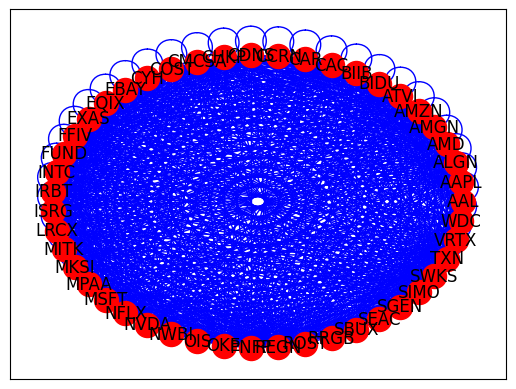

In [19]:
nx.draw_networkx(Graph_pearson, pos=nx.circular_layout(Graph_pearson), node_color='r', edge_color='b')

# Create GCN layer. Pearson

# Find all stocks = nodes

In [20]:
# improvement: make sure only stocks/nodes that are in the graph are taken
all_stock_nodes = df_s_transpose_pearson.index.to_list()
all_stock_nodes

['AAL',
 'AAPL',
 'ALGN',
 'AMD',
 'AMGN',
 'AMZN',
 'ATVI',
 'BIDU',
 'BIIB',
 'CAC',
 'CAR',
 'CCRN',
 'CDNS',
 'CHKP',
 'CMCSA',
 'COST',
 'CYH',
 'EBAY',
 'EQIX',
 'EXAS',
 'FFIV',
 'FUND',
 'INTC',
 'IRBT',
 'ISRG',
 'LRCX',
 'MITK',
 'MKSI',
 'MPAA',
 'MSFT',
 'NFLX',
 'NVDA',
 'NWBI',
 'OIS',
 'OKE',
 'PNFP',
 'REGN',
 'ROST',
 'RRGB',
 'SBUX',
 'SEAC',
 'SGEN',
 'SIMO',
 'SWKS',
 'TXN',
 'VRTX',
 'WDC']

# Find all edges between nodes

In [21]:
source = [];
target = [];
edge_feature = [];

for aStock in all_stock_nodes:
    for anotherStock in all_stock_nodes:
        if df_s_transpose_pearson[aStock][anotherStock] > 0:
            #print(df_s_transpose_pearson[aStock][anotherStock])
            source.append(aStock)
            target.append(anotherStock)
            edge_feature.append(1)
            
source, target, edge_feature            

(['AAL',
  'AAL',
  'AAL',
  'AAL',
  'AAL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'ALGN',
  'AMD',
  'AMD',
  'AMD',
  'AMD',
  'AMD',
  'AMD',
  'AMD',
  'AMD',
  'AMD',
  'AMD',
  'AMD',
  'AMD',
  'AMD',
  'AMD',
  'AMD',
  'AMD',
  'AMD',
  'AMD',
  'AMD',
  'AMD',
  'AMD',
  'AMD',
  'AMD'

In [22]:
# https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html
pearson_edges = pd.DataFrame(
    {"source": source, "target": target}
)

pearson_edges_data = pd.DataFrame(
    {"source": source, "target": target, "edge_feature": edge_feature}
)


pearson_edges[:10]

,source,target
0,AAL,AAL
1,AAL,BIIB
2,AAL,MPAA
3,AAL,RRGB
4,AAL,WDC
5,AAPL,AAPL
6,AAPL,ALGN
7,AAPL,AMD
8,AAPL,AMGN
9,AAPL,AMZN


In [23]:
# Graph with No Feature Data, No node data, only edges

pearson_graph = StellarGraph(edges = pearson_edges, node_type_default="corner", edge_type_default="line")
#pearson_graph = StellarGraph(nodes = all_stock_nodes, edges = pearson_edges)
# graph = sg.StellarGraph(all_stock_nodes, square_edges)
print(pearson_graph.info())

In [24]:
# Trying to have the time series data as part of the nodes

In [25]:
df_s_transpose

Ticker,AAL,AAPL,ALGN,AMD,AMGN,AMZN,ATVI,BIDU,BIIB,CAC,...,ROST,RRGB,SBUX,SEAC,SGEN,SIMO,SWKS,TXN,VRTX,WDC
Date,,,,,,,,,,,,,,,,,,,,,
2005-11-11,31.440432,1.873492,6.980000,24.760000,60.792927,2.134000,7.398454,7.005000,44.910000,14.710688,...,5.587360,52.750000,12.496881,7.5300,5.660000,10.920407,4.438297,21.876820,26.330000,9.767348
2005-11-14,31.817526,1.870753,6.850000,25.000000,61.205231,2.126500,7.575770,7.000000,43.740002,14.694822,...,5.630208,52.689999,12.563198,7.5900,5.630000,11.422858,4.411180,22.411083,26.190001,9.610318
2005-11-15,31.940084,1.896021,6.730000,25.500000,61.205231,2.222500,7.429485,6.882000,43.810001,14.488638,...,5.396688,52.130001,12.550764,7.2500,5.370000,11.666232,4.375022,22.122852,25.990000,9.516099
2005-11-16,31.676109,1.977305,6.590000,25.549999,60.905376,2.265000,7.478247,6.950000,43.720001,14.357786,...,5.364550,52.160000,12.608795,7.1200,5.270000,11.265841,4.311746,22.179094,25.059999,9.955786
2005-11-17,32.354889,1.964215,6.300000,25.889999,62.277153,2.337000,7.203409,7.318000,44.810001,14.397439,...,5.570221,52.540001,12.940383,7.4000,5.420000,11.187335,4.411180,22.411083,26.129999,10.803759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-07,14.770000,145.416443,248.979996,76.360001,243.400879,109.220001,76.540001,143.479996,215.580002,44.036304,...,75.070000,7.770000,77.760002,0.5400,179.000000,83.089996,96.510002,154.460007,290.010010,46.029999
2022-12-08,15.250000,171.814987,289.000000,100.830002,244.800354,143.550003,80.790001,140.360001,220.990005,47.541328,...,90.120003,8.800000,88.309998,0.5800,170.139999,82.610001,113.410004,185.380005,294.519989,50.669998
2022-12-09,14.470000,163.159332,267.790009,84.639999,235.994522,136.449997,78.129997,139.559998,212.880005,45.273212,...,94.980003,8.270000,89.070000,0.4800,150.100006,73.410004,103.620003,170.580002,293.480011,43.270000


# Structure the Feature Matrix so that it can be passed to the GCN

In [26]:
df_s_transpose_feature = df_s_transpose.reset_index(drop = True, inplace=False)
# df_s_transpose_feature =  df_s_transpose_feature.values.tolist()
# print(df_s_transpose_feature.values.tolist())
#df_s_transpose_feature['WY'].values

In [27]:
node_Data = [];
for x in all_stock_nodes:
    node_Data.append( df_s_transpose_feature[x].values)
    
    
node_Data    

[array([31.44043159, 31.81752586, 31.94008446, ..., 14.47000027,
        12.69999981, 13.91499996]),
 array([  1.873492  ,   1.87075317,   1.89602113, ..., 163.15933228,
        138.11088562, 142.32000732]),
 array([  6.98000002,   6.8499999 ,   6.73000002, ..., 267.79000854,
        208.05000305, 195.41000366]),
 array([24.76000023, 25.        , 25.5       , ..., 84.63999939,
        57.84999847, 69.16999817]),
 array([ 60.79292679,  61.20523071,  61.20523071, ..., 235.99452209,
        244.75419617, 275.04000854]),
 array([  2.13400006,   2.12649989,   2.22250009, ..., 136.44999695,
        112.90000153,  88.60500336]),
 array([ 7.39845419,  7.5757699 ,  7.42948484, ..., 78.12999725,
        73.5       , 74.76999664]),
 array([  7.00500011,   7.        ,   6.88199997, ..., 139.55999756,
        107.47000122, 114.94999695]),
 array([ 44.90999985,  43.74000168,  43.81000137, ..., 212.88000488,
        253.66999817, 286.17999268]),
 array([14.71068764, 14.69482231, 14.48863792, ..., 45.

In [28]:
pearson_graph_node_data = pd.DataFrame(node_Data, index = all_stock_nodes)

pearson_graph_node_data

,0,1,2,3,4,5,6,7,8,9,...,4282,4283,4284,4285,4286,4287,4288,4289,4290,4291
AAL,31.440432,31.817526,31.940084,31.676109,32.354889,31.157598,30.158302,30.639097,31.148174,30.969065,...,14.140000,14.430000,18.500000,17.129999,15.490000,14.770000,15.250000,14.470000,12.700000,13.915000
AAPL,1.873492,1.870753,1.896021,1.977305,1.964215,1.965432,1.977609,2.025102,2.043063,2.110952,...,141.169998,148.029999,174.517136,166.904938,142.126480,145.416443,171.814987,163.159332,138.110886,142.320007
ALGN,6.980000,6.850000,6.730000,6.590000,6.300000,6.440000,6.270000,6.290000,6.750000,6.900000,...,191.830002,196.660004,539.469971,406.230011,259.529999,248.979996,289.000000,267.790009,208.050003,195.410004
AMD,24.760000,25.000000,25.500000,25.549999,25.889999,26.740000,27.040001,27.090000,26.219999,26.520000,...,73.389999,77.629997,137.470001,95.099998,87.059998,76.360001,100.830002,84.639999,57.849998,69.169998
AMGN,60.792927,61.205231,61.205231,60.905376,62.277153,62.382114,63.281658,62.861828,62.082233,62.059765,...,281.989990,286.399994,224.663834,244.462387,239.261063,243.400879,244.800354,235.994522,244.754196,275.040009
AMZN,2.134000,2.126500,2.222500,2.265000,2.337000,2.399000,2.399500,2.442500,2.412000,2.403000,...,92.419998,96.540001,165.207001,150.787506,106.930496,109.220001,143.550003,136.449997,112.900002,88.605003
ATVI,7.398454,7.575770,7.429485,7.478247,7.203409,6.729092,6.587240,6.503015,6.529612,6.520747,...,74.339996,73.949997,64.427040,79.070000,77.379997,76.540001,80.790001,78.129997,73.500000,74.769997
BIDU,7.005000,7.000000,6.882000,6.950000,7.318000,7.092000,7.160000,7.472000,8.049000,8.377000,...,99.639999,108.599998,159.360001,130.990005,107.879997,143.479996,140.360001,139.559998,107.470001,114.949997
BIIB,44.910000,43.740002,43.810001,43.720001,44.810001,45.330002,45.119999,44.759998,44.830002,44.490002,...,291.410004,305.170013,225.339996,208.059998,194.320007,215.580002,220.990005,212.880005,253.669998,286.179993
CAC,14.710688,14.694822,14.488638,14.357786,14.397439,14.318138,14.472775,14.373650,14.314165,14.345891,...,42.709999,43.779999,48.682377,45.714531,42.593620,44.036304,47.541328,45.273212,41.460003,42.345001


# Graph with feature as part of Nodes

In [29]:
pearson_graph_with_node_features = StellarGraph(pearson_graph_node_data, edges = pearson_edges, node_type_default = "corner", edge_type_default = "line")
print(pearson_graph_with_node_features.info())


StellarGraph: Undirected multigraph
 Nodes: 47, Edges: 1573

 Node types:
  corner: [47]
    Features: float32 vector, length 4292
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [1573]
        Weights: all 1 (default)
        Features: none


In [30]:
# Generator
generator = FullBatchNodeGenerator(pearson_graph_with_node_features, method = "gcn", sparse = False)

Using GCN (local pooling) filters...


No need for this block

Graph with feature as part of both Nodes and edges
although Edge data is not required


pearson_graph_with_edge_features = StellarGraph(pearson_graph_node_data, edges = pearson_edges, node_type_default="corner", edge_type_default="line")
print(pearson_graph_with_edge_features.info())
generator = FullBatchNodeGenerator(pearson_graph_with_edge_features, method = "gcn")

In [31]:
# Train Test Split

In [32]:
train_subjects, test_subjects = model_selection.train_test_split(
    pearson_graph_node_data #, train_size = 6, test_size = 4
)
# , train_size=6, test_size=None, stratify=pearson_graph_node_data

val_subjects, test_subjects_ = model_selection.train_test_split(
    test_subjects #, test_size = 2
)

#, train_size=500, test_size=None, stratify=test_subjects

#val_subjects, test_subjects = model_selection.train_test_split(
#    test_subjects, train_size=500, test_size=None, stratify=test_subjects
#)

train_subjects.shape, test_subjects.shape, val_subjects.shape, test_subjects_.shape

((35, 4292), (12, 4292), (9, 4292), (3, 4292))

In [33]:
pearson_graph_node_data

,0,1,2,3,4,5,6,7,8,9,...,4282,4283,4284,4285,4286,4287,4288,4289,4290,4291
AAL,31.440432,31.817526,31.940084,31.676109,32.354889,31.157598,30.158302,30.639097,31.148174,30.969065,...,14.140000,14.430000,18.500000,17.129999,15.490000,14.770000,15.250000,14.470000,12.700000,13.915000
AAPL,1.873492,1.870753,1.896021,1.977305,1.964215,1.965432,1.977609,2.025102,2.043063,2.110952,...,141.169998,148.029999,174.517136,166.904938,142.126480,145.416443,171.814987,163.159332,138.110886,142.320007
ALGN,6.980000,6.850000,6.730000,6.590000,6.300000,6.440000,6.270000,6.290000,6.750000,6.900000,...,191.830002,196.660004,539.469971,406.230011,259.529999,248.979996,289.000000,267.790009,208.050003,195.410004
AMD,24.760000,25.000000,25.500000,25.549999,25.889999,26.740000,27.040001,27.090000,26.219999,26.520000,...,73.389999,77.629997,137.470001,95.099998,87.059998,76.360001,100.830002,84.639999,57.849998,69.169998
AMGN,60.792927,61.205231,61.205231,60.905376,62.277153,62.382114,63.281658,62.861828,62.082233,62.059765,...,281.989990,286.399994,224.663834,244.462387,239.261063,243.400879,244.800354,235.994522,244.754196,275.040009
AMZN,2.134000,2.126500,2.222500,2.265000,2.337000,2.399000,2.399500,2.442500,2.412000,2.403000,...,92.419998,96.540001,165.207001,150.787506,106.930496,109.220001,143.550003,136.449997,112.900002,88.605003
ATVI,7.398454,7.575770,7.429485,7.478247,7.203409,6.729092,6.587240,6.503015,6.529612,6.520747,...,74.339996,73.949997,64.427040,79.070000,77.379997,76.540001,80.790001,78.129997,73.500000,74.769997
BIDU,7.005000,7.000000,6.882000,6.950000,7.318000,7.092000,7.160000,7.472000,8.049000,8.377000,...,99.639999,108.599998,159.360001,130.990005,107.879997,143.479996,140.360001,139.559998,107.470001,114.949997
BIIB,44.910000,43.740002,43.810001,43.720001,44.810001,45.330002,45.119999,44.759998,44.830002,44.490002,...,291.410004,305.170013,225.339996,208.059998,194.320007,215.580002,220.990005,212.880005,253.669998,286.179993
CAC,14.710688,14.694822,14.488638,14.357786,14.397439,14.318138,14.472775,14.373650,14.314165,14.345891,...,42.709999,43.779999,48.682377,45.714531,42.593620,44.036304,47.541328,45.273212,41.460003,42.345001


In [34]:
train_targets = train_subjects; 
val_targets = val_subjects; 
test_targets = test_subjects; 

In [35]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [36]:
# debug
train_subjects.index, 
train_targets

,0,1,2,3,4,5,6,7,8,9,...,4282,4283,4284,4285,4286,4287,4288,4289,4290,4291
INTC,16.084715,16.238329,16.052708,15.943900,16.071915,16.193523,16.161516,16.743967,17.051201,17.160017,...,28.900000,30.070000,55.740002,46.500000,42.840000,37.209999,36.110001,31.559999,25.330000,28.115499
ALGN,6.980000,6.850000,6.730000,6.590000,6.300000,6.440000,6.270000,6.290000,6.750000,6.900000,...,191.830002,196.660004,539.469971,406.230011,259.529999,248.979996,289.000000,267.790009,208.050003,195.410004
OKE,5.302960,5.381814,5.312818,5.322675,5.336474,5.431100,5.438983,5.496155,5.531640,5.523754,...,64.910004,66.919998,61.528793,70.809998,62.790001,55.000000,64.349998,63.869999,53.459999,64.739998
NVDA,2.606570,2.661705,2.667829,2.658641,2.776565,2.771203,2.820211,2.895253,2.886830,2.915162,...,156.389999,169.229996,279.989990,215.039993,161.750000,150.820007,187.089996,145.050003,115.000000,171.285004
IRBT,36.509998,32.700001,30.600000,30.860001,30.160000,29.500000,28.450001,29.889999,29.740000,29.740000,...,51.360001,52.090000,67.129997,56.090000,44.630001,38.700001,59.709999,58.680000,55.980000,49.680000
EXAS,1.750000,1.760000,1.630000,1.610000,1.690000,1.640000,1.610000,1.600000,1.560000,1.550000,...,41.189999,44.950001,75.820000,67.400002,48.259998,46.669998,42.709999,41.610001,31.620001,46.169998
RRGB,52.750000,52.689999,52.130001,52.160000,52.540001,54.220001,56.080002,57.400002,56.799999,56.660000,...,8.080000,8.290000,16.100000,14.360000,8.730000,7.770000,8.800000,8.270000,7.780000,7.190000
CDNS,16.500000,16.820000,17.160000,16.950001,16.950001,16.799999,17.290001,17.309999,17.309999,17.040001,...,163.520004,172.039993,170.179993,153.369995,135.820007,154.220001,188.830002,175.020004,147.970001,166.085007
BIIB,44.910000,43.740002,43.810001,43.720001,44.810001,45.330002,45.119999,44.759998,44.830002,44.490002,...,291.410004,305.170013,225.339996,208.059998,194.320007,215.580002,220.990005,212.880005,253.669998,286.179993
ATVI,7.398454,7.575770,7.429485,7.478247,7.203409,6.729092,6.587240,6.503015,6.529612,6.520747,...,74.339996,73.949997,64.427040,79.070000,77.379997,76.540001,80.790001,78.129997,73.500000,74.769997


# This was there, but for classification, model does not match. I am changing
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator , dropout=0.5
)
x_inp, x_out = gcn.in_out_tensors()
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)


In [37]:
# train data size
# it is not must to use a number like unit_count
unit_count = train_subjects.shape[0]
unit_count

35

In [38]:
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow import keras

# layer_sizes = [32, 1, 32, 1, 32, 1]
# activations = ["relu", 'linear', "relu", 'linear',"relu", 'linear']

layer_sizes = [32, 32]
activations = ["relu", "relu"]

gcn = GCN(layer_sizes = layer_sizes, activations = activations, generator = generator) #, dropout = 0.5
x_inp, x_out = gcn.in_out_tensors()

#x_out = Conv1D(filters = 2, kernel_size = 2)(x_out)
#x_out = MaxPool1D(pool_size=2)(x_out)
#x_out = Conv1D(filters = 32, kernel_size = sum(layer_sizes))(x_out)
#prediction = keras.layers.Reshape((-1,))(prediction)
#x_out = keras.layers.Reshape((1,16))(x_out)
#x_out = GCN(layer_sizes = layer_sizes, activations = activations, generator = generator)(x_out) #, dropout = 0.5

# predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)
predictions = layers.Dense(units = train_targets.shape[1], activation = "linear")(x_out)
x_out, 
x_inp, x_out

([<KerasTensor: shape=(1, 47, 4292) dtype=float32 (created by layer 'input_1')>,
  <KerasTensor: shape=(1, None) dtype=int32 (created by layer 'input_2')>,
  <KerasTensor: shape=(1, 47, 47) dtype=float32 (created by layer 'input_3')>],
 <KerasTensor: shape=(1, None, 32) dtype=float32 (created by layer 'gather_indices')>)

In [39]:
# debug
vars(generator)

{'graph': <stellargraph.core.graph.StellarGraph at 0x282db6c6400>,
 'name': None,
 'k': 1,
 'teleport_probability': 0.1,
 'method': 'gcn',
 'node_list': Index(['AAL', 'AAPL', 'ALGN', 'AMD', 'AMGN', 'AMZN', 'ATVI', 'BIDU', 'BIIB',
        'CAC', 'CAR', 'CCRN', 'CDNS', 'CHKP', 'CMCSA', 'COST', 'CYH', 'EBAY',
        'EQIX', 'EXAS', 'FFIV', 'FUND', 'INTC', 'IRBT', 'ISRG', 'LRCX', 'MITK',
        'MKSI', 'MPAA', 'MSFT', 'NFLX', 'NVDA', 'NWBI', 'OIS', 'OKE', 'PNFP',
        'REGN', 'ROST', 'RRGB', 'SBUX', 'SEAC', 'SGEN', 'SIMO', 'SWKS', 'TXN',
        'VRTX', 'WDC'],
       dtype='object'),
 'Aadj': <47x47 sparse matrix of type '<class 'numpy.float64'>'
 	with 1573 stored elements in Compressed Sparse Row format>,
 'use_sparse': False,
 'features': array([[ 31.440432 ,  31.817526 ,  31.940084 , ...,  14.47     ,
          12.7      ,  13.915    ],
        [  1.873492 ,   1.8707532,   1.8960211, ..., 163.15933  ,
         138.11089  , 142.32     ],
        [  6.98     ,   6.85     ,   6.73  

In [40]:
g_int = {'graph': '<stellargraph.core.graph.StellarGraph at 0x1a4cd19a550>',
 'name': None,
 'k': 1,
 'teleport_probability': 0.1,
 'method': 'gcn',
 'node_list': (['AAL', 'AAPL', 'ALGN', 'AMD', 'AMGN', 'AMZN', 'ATVI', 'BIDU', 'BIIB',
        'CAC', 'CAR', 'CCRN', 'CDNS', 'CHKP', 'CMCSA', 'COST', 'CYH', 'EBAY',
        'EQIX', 'EXAS', 'FFIV', 'FUND', 'INTC', 'IRBT', 'ISRG', 'LRCX', 'MITK',
        'MKSI', 'MPAA', 'MSFT', 'NFLX', 'NVDA', 'NWBI', 'OIS', 'OKE', 'PNFP',
        'REGN', 'ROST', 'RRGB', 'SBUX', 'SEAC', 'SGEN', 'SIMO', 'SWKS', 'TXN',
        'VRTX', 'WDC'],
       ),
 'use_sparse': False,
 'features': df_s_transpose_feature }

#g_int = (FullBatchNodeGenerator) (g_int)

# experiment: After Pooling send to CNN or GCN

In [42]:
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow import keras

# layer_sizes = [32, 1, 32, 1, 32, 1]
# activations = ["relu", 'linear', "relu", 'linear',"relu", 'linear']

layer_sizes = [unit_count, unit_count]
activations = ["relu", "relu"]




gcn = GCN(layer_sizes = layer_sizes, activations = activations, generator = generator, dropout = 0.5) #, dropout = 0.5
x_inp, x_out = gcn.in_out_tensors()




In [46]:
vars(x_out)

{'_type_spec': TensorSpec(shape=(1, None, 35), dtype=tf.float32, name=None),
 '_inferred_value': None,
 '_name': 'gather_indices_1/GatherV2:0',
 '_keras_history': KerasHistory(layer=<stellargraph.layer.misc.GatherIndices object at 0x00000282DB6B3460>, node_index=0, tensor_index=0)}

In [ ]:
# closely related to previous block. keeo or remove together
gcn = GCN(layer_sizes = layer_sizes, activations = activations, generator = (FullBatchNodeGenerator) g_int, dropout = 0.5) #, dropout = 0.5


g_int = layers.Dense(units = train_targets.shape[1], activation = "relu")(x_out)
print(g_int)
pearson_graph_with_node_features_int = StellarGraph(nodes = g_int, edges = pearson_edges, node_type_default="corner", edge_type_default="line")
print(pearson_graph_with_node_features_int.info())



#x_out = Conv1D(filters = 2, kernel_size = 2)(x_out)
#x_out = MaxPool1D(pool_size=2)(x_out)
#x_out = Conv1D(filters = 32, kernel_size = sum(layer_sizes))(x_out)
#prediction = keras.layers.Reshape((-1,))(prediction)
#x_out = keras.layers.Reshape((1,16))(x_out)
#x_out = GCN(layer_sizes = layer_sizes, activations = activations, generator = generator)(x_out) #, dropout = 0.5

# predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)
#sg.StellarGraph(x_out)
predictions = layers.Dense(units = train_targets.shape[1], activation = "relu")(x_out)
#sg.StellarGraph(x_out)
#predictions
#generator
x_out
#gcn
#gcnInt = GCN(layer_sizes = layer_sizes, activations = activations, generator = predictions, dropout = 0.5) #, dropout = 0.5
#generatorInt = FullBatchNodeGenerator(predictions, method = "gcn")

#predictions = layers.Dense(units = train_targets.shape[1], activation = "linear")(x_out)
#x_out, 
#x_inp, x_out

In [ ]:
stop

# Experiment with DeepGraphCNN
# https://stellargraph.readthedocs.io/en/latest/demos/graph-classification/dgcnn-graph-classification.html

# Generator
from stellargraph.mapper import PaddedGraphGenerator
graphs = []
graphs.append(pearson_graph_with_node_features)
generator = PaddedGraphGenerator(graphs)

k = unit_count  # the number of rows for the output tensor
layer_sizes = [32, 32, 32, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["relu", "relu", "tanh", "tanh"],
    k=k,
    bias=False,
    generator=generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

print(graphs[0].info())
x_inp


summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)


x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units=128, activation="relu")(x_out)
x_out = Dropout(rate=0.5)(x_out)

#predictions = Dense(units=1, activation="linear")(x_out)
predictions = layers.Dense(units = train_targets.shape[1], activation = "linear")(x_out)

model = Model(inputs=x_inp, outputs=predictions)

#model.compile(
#    optimizer=optimizers.Adam(lr=0.0001), loss=binary_crossentropy, metrics=["acc"],
#)

model.compile(loss='mean_absolute_error', optimizer=optimizers.Adam(learning_rate=0.1), metrics=['mean_squared_error'])

train_gen = generator.flow(
    train_subjects.index,
    targets=train_subjects.values,
    batch_size=50,
    symmetric_normalization=False,
)

test_gen = generator.flow(
    test_targets.index,
    targets=test_targets.values,
    batch_size=1,
    symmetric_normalization=False,
)

history = model.fit(
    train_gen, epochs=10, verbose=1, validation_data=data_valid, shuffle=False,
)

# https://keras.io/api/callbacks/early_stopping/
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor = "val_mean_squared_error", patience = 50, restore_best_weights = True)

data_valid = val_gen #[:1][:4];
train_gen_data = train_gen #[:1][:4];

history = model.fit( train_gen_data, epochs = 100, validation_data = data_valid, verbose = 2,    
    # shuffling = true means shuffling the whole graph
    shuffle = False, callbacks = [es_callback],
)
sg.utils.plot_history(history)

# [1]

# Experiment with Models

from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow import keras

# layer_sizes = [32, 1, 32, 1, 32, 1]
# activations = ["relu", 'linear', "relu", 'linear',"relu", 'linear']

layer_sizes = [32, 32]
activations = ["relu", "relu"]

gcn = GCN(layer_sizes = layer_sizes, activations = activations, generator = generator) #, dropout = 0.5
x_inp, x_out = gcn.in_out_tensors()
xout = x_out

#x_out = Conv1D(filters = 7, kernel_size = 7)(x_out)
input_shape = (4, 10, 128)
x_out = Conv1D(32, 3, activation = 'relu', input_shape = x_out[1:] )(x_out)
#x_out = MaxPool1D(pool_size=2)(x_out)
#x_out = Conv1D(filters = 32, kernel_size = sum(layer_sizes))(x_out)
#prediction = keras.layers.Reshape((-1,))(prediction)
#x_out = keras.layers.Reshape((1,16))(x_out)

# Generator
#generator2 = FullBatchNodeGenerator(x_out, method = "gcn")
gcn2 = GCN(layer_sizes = layer_sizes, activations = activations, generator = generator)#(x_out) #, dropout = 0.5

# predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)
predictions = layers.Dense(units = train_targets.shape[1], activation = "linear")(x_out)
#x_out, 
x_inp, x_out, type(xout),  vars(gcn), 
x_out[1:]

import tensorflow as tf
input_shape = (4, 10, 128)
x = tf.random.normal(input_shape)
y = keras.layers.Conv1D(32, 3, activation='relu',input_shape=input_shape[1:])(x)
#print(y.shape)

#https://keras.io/api/layers/convolution_layers/convolution1d
x_out_cnn = Conv1D(32, 3, activation='relu',input_shape=input_shape[1:])(x_out)
x, 
input_shape[1:], x_out_cnn

# Not my code
# https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/
# univariate cnn example
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=1000, verbose=0)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

x_out, vars(gcn)

In [ ]:
# Models

In [ ]:
# loss functions: https://keras.io/api/losses/

model = Model(inputs=x_inp, outputs=predictions)
'''
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.1),
    loss=losses.MeanSquaredError(),
    metrics=["acc"],
)
'''

model.compile( 
    loss = 'mean_absolute_error', 
    optimizer = optimizers.Adam(learning_rate = 0.1), 
    # metrics=['mean_squared_error']
    metrics=[
        metrics.MeanSquaredError(),
        metrics.AUC(),
    ]
)

In [ ]:
len(x_inp) , predictions.shape, print(model.summary())

In [ ]:
len(val_subjects)
test_subjects_ = test_subjects[:len(val_subjects)]

In [ ]:
# hard coded size adjustments
test_subjects_ = test_subjects[:len(val_subjects)]

val_gen = generator.flow(val_subjects.index, test_subjects_)
#train_gen[1], val_gen[1]

train_gen[:1][:4]

In [ ]:
# https://keras.io/api/callbacks/early_stopping/
from tensorflow.keras.callbacks import EarlyStopping

epochs_to_test = 10
patience_to_test = 10

es_callback = EarlyStopping(monitor = "val_mean_squared_error", patience = patience_to_test, restore_best_weights = True)

data_valid = val_gen #[:1][:4];
train_gen_data = train_gen #[:1][:4];

history = model.fit( train_gen_data, epochs = epochs_to_test, validation_data = data_valid, verbose = 2,    
    # shuffling = true means shuffling the whole graph
    shuffle = False, callbacks = [es_callback],
)
sg.utils.plot_history(history)

# [1]

In [ ]:
val_subjects, 
test_subjects

In [ ]:
test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))
    

# Show the predicted prices by the Model

At this point, I still need to make sense of what GCN ( and CNN) combination + MLP is predicting. 
I am just displaying the output. 
It appears that price is predicted for each timestamp (day)

In [ ]:
all_nodes = pearson_graph_node_data.index;
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

all_predictions, all_predictions.shape, pearson_graph_node_data.shape

In [ ]:
vars(all_gen)

In [ ]:
train_gen[:1][:4]

In [ ]:
pearson_graph_node_data

References:



[1] Node classification with Graph Convolutional Network (GCN). https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gcn-node-classification.html 


[2] Loading data into StellarGraph from Pandas. https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html

[3] Load Timeseries https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-numpy.html

[4] NetworkX: https://networkx.org/documentation/stable/reference/introduction.html 

[5]  StellerGraph and Networkx https://stellargraph.readthedocs.io/en/latest/demos/basics/loading-networkx.html 

[6] Select StellerGraph Algorithm : https://stellargraph.readthedocs.io/en/stable/demos/#find-a-demo-for-an-algorithm 
[link text](https://)


Learning: 
GNN/GCN/Keras
https://www.youtube.com/watch?v=0KH95BEz370


Install StellarGraph:
https://pypi.org/project/stellargraph/#install-stellargraph-using-pypi


May want to use without Stellar
https://keras.io/examples/graph/gnn_citations/

to get feature data from pandas dataframe: 
https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html


Create graph properly:
https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html    

https://stellargraph.readthedocs.io/en/v0.11.0/api.html


Graph Regression Dataset
https://paperswithcode.com/task/graph-regression/codeless

StellerGraph Reference:
https://stellargraph.readthedocs.io/en/stable/demos/time-series/gcn-lstm-time-series.html
https://stellargraph.readthedocs.io

GRaph CNN or similar
It has multiple GCN layers and one 1d CNN + ... this idea might help
https://stellargraph.readthedocs.io/en/stable/demos/graph-classification/dgcnn-graph-classification.html?highlight=cnn

# References -- exploring ideas on the GCN-CNN
https://ieeexplore.ieee.org/document/9149910

https://antonsruberts.github.io/graph/gcn/

This may work. As Unit GCN is created also unit tcn. This may give the opportunity to customize to product the correct output
https://github.com/lshiwjx/2s-AGCN  https://paperswithcode.com/paper/non-local-graph-convolutional-networks-for

    

# from scracth and equations
https://towardsdatascience.com/understanding-graph-convolutional-networks-for-node-classification-a2bfdb7aba7b

https://jonathan-hui.medium.com/graph-convolutional-networks-gcn-pooling-839184205692

# Misc Code if any

Set learning rate dynamically
https://stackoverflow.com/questions/57301698/how-to-change-a-learning-rate-for-adam-in-tf2